## Todos

- calculate centrality measure only once
- replace randomize_graph in basic_graph_analyzer.py by utils function

In [1]:
from src.analysis.basic_graph_analyzer import BasicGraphAnalyzer
from src.analysis.centrality_analyzer import CentralityAnalyzer
from src.analysis.scale_free_analyzer import ScaleFreeAnalyzer


In [2]:
from graph_tool import openmp_set_num_threads

# Set the number of threads to use
openmp_set_num_threads(8)

In [3]:
from graph_tool.all import load_graph

file_path = 'outputs/graphs/Machine_learning.gt'

G = load_graph(file_path)

num_nodes = G.num_vertices()
num_edges = G.num_edges()

print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")

Number of nodes: 75217
Number of edges: 26149964


In [ ]:
from graph_tool.draw import sfdp_layout
from graph_tool.draw import graph_draw

pos = sfdp_layout(G)
graph_draw(G, pos)


Processing vertices: 100%|██████████| 75217/75217 [02:15<00:00, 556.49vertex/s]


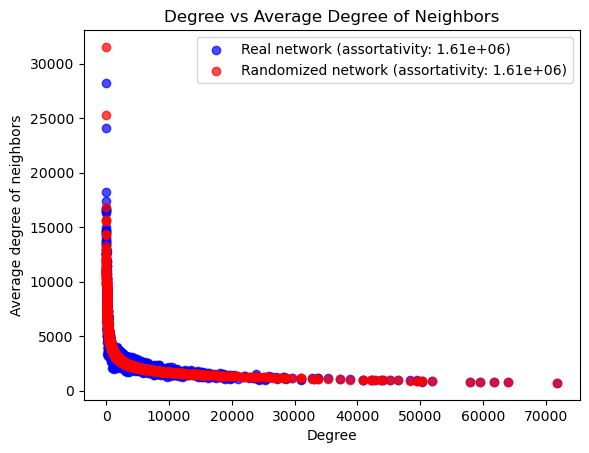

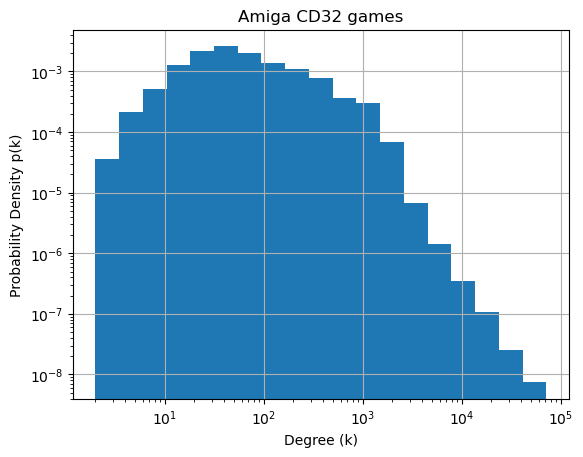

In [4]:
basic_graph_analyzer = BasicGraphAnalyzer(G)
basic_graph_analyzer.plot_degree_vs_avg_degree("Degree vs Average Degree of Neighbors", plot_randomized=True)
basic_graph_analyzer.plot_log_log_probability_density('Machine learning')

In [ ]:
centrality_analyzer = CentralityAnalyzer(G)
centrality_analyzer.plot_centralities()
centrality_analyzer.plot_centralities_comparison()
centrality_analyzer.plot_centralities_comparison_randomized()

Calculating degrees...
Degrees calculated in 0.00 seconds.

Calculating eigenvector...
Eigenvector centrality calculated in 1.64 seconds.

Calculating closeness...


In [60]:
import powerlaw
import numpy as np
import matplotlib.pyplot as plt
from scipy import special

from scipy.optimize import curve_fit
import numpy as np

def fit_power_law(self, degrees):
    fit = powerlaw.Fit(degrees)
    return fit.power_law.alpha, fit.power_law.sigma


class ScaleFreeAnalyzer():
    def __init__(self, G, is_weighted=False):
        self.G = G
        self.is_weighted = is_weighted

    def calculate_poisson_degree_distribution(self, degrees, logarithmic_bins):
        lamda = np.mean(degrees)
        x = logarithmic_bins
        y = np.exp(-lamda) * np.power(lamda, x) / special.factorial(x)
        x = x[y > 0]
        y = y[y > 0]
        return x, y

    def calculate_exponential_degree_distribution(self, degrees, logarithmic_bins):
        lamda = np.mean(degrees)
        beta = 1 / lamda
        x = logarithmic_bins
        y = beta * np.exp(-beta * x)
        # remove entries with 0 probability
        x = x[y > 0]
        y = y[y > 0]
        return x, y
    
    def get_degrees(self, G, weighted=False):
        if weighted:
            weights = G.edge_properties["weight"]
            return [sum(weights[e] for e in v.out_edges()) for v in G.vertices()]
        else:
            return G.get_out_degrees(G.get_vertices())

    def power_law(x, a, b):
        return a * np.power(x, b)

    def fit_power_law(self, data):
        data = data[data > 0]
        
        x = np.arange(1, len(data) + 1)
        
        popt, pcov = curve_fit(self.power_law, x, data)
        
        perr = np.sqrt(np.diag(pcov))
        
        return popt[0], popt[1], perr

    def calculate_power_law_degree_distribution(self):
        print(50*'-')
        degrees = self.get_degrees(self.G, weighted=self.is_weighted)
        alpha, sigma, _ = self.fit_power_law(degrees)
        print()
        print()
        print(f'Exponent: {alpha}')
        print(f'Error: {sigma}')

    def plot_degree_distribution(self, graph, title):
        degrees = self.get_degrees(graph, self.is_weighted)
        title = f"Graph: {title}"
        print(f"{20*'-'} {title} {20*'-'}")
        print(f"Graph average degree: {np.mean(degrees)}")
        print(f"Graph max degree: {max(degrees)}")
        print(f"Graph min degree: {min(degrees)}")
        print((42 + len(title))*'-')

        logarithmic_bins = np.logspace(np.log10(min(degrees)), np.log10(max(degrees)), num=20)

        hist_densitiy, bin_edges = np.histogram(degrees, bins=logarithmic_bins, density=True)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  
        bin_centers = bin_centers[hist_densitiy > 0]
        hist_densitiy = hist_densitiy[hist_densitiy > 0]
        plt.plot(bin_centers, hist_densitiy, '-o', label='Degree', alpha=0.8)

        x,y = self.calculate_poisson_degree_distribution(degrees, logarithmic_bins)
        plt.plot(x, y, color='g', linestyle='-', label='Poisson Distribution')

        x,y = self.calculate_exponential_degree_distribution(degrees, logarithmic_bins)
        plt.plot(x, y, color='b', linestyle='-', label='Exponential Distribution')

        filtered_degrees = [d for d in degrees if d > 5*10**3]

        fit = powerlaw.Fit(filtered_degrees, discrete=True, xmin=1)
        fit.power_law.plot_pdf(color='r', linestyle='--', label='Power Law Fit')

        plt.xscale('log')
        plt.yscale('log')
        plt.ylim([0.001*min(hist_densitiy), 100*max(hist_densitiy)])
        plt.legend()
        plt.title(f'Degree Distribution {title}')
        plt.xlabel('Degree')
        plt.ylabel('Probability Density')
        plt.show()

In [88]:
import powerlaw
import numpy as np
import matplotlib.pyplot as plt
from scipy import special
from scipy.optimize import curve_fit

class ScaleFreeAnalyzer:
    def __init__(self, G, is_weighted=False):
        self.G = G
        self.is_weighted = is_weighted
    
    def fit_power_law(self, degrees):
        # Using powerlaw package for fitting
        fit = powerlaw.Fit(degrees, discrete=True)
        return fit.power_law.alpha, fit.power_law.sigma
    
    def calculate_poisson_degree_distribution(self, degrees, logarithmic_bins):
        lamda = np.mean(degrees)
        x = logarithmic_bins
        y = np.exp(-lamda) * np.power(lamda, x) / special.factorial(x)
        x = x[y > 0]
        y = y[y > 0]
        return x, y
    
    def calculate_exponential_degree_distribution(self, degrees, logarithmic_bins):
        lamda = np.mean(degrees)
        beta = 1 / lamda
        x = logarithmic_bins
        y = beta * np.exp(-beta * x)
        x = x[y > 0]
        y = y[y > 0]
        return x, y
    
    def get_degrees(self, weighted=False):  # Removed G parameter since we have self.G
        if weighted:
            try:
                # For NetworkX graphs
                return [d for _, d in self.G.degree(weight='weight')]
            except AttributeError:
                # For graph-tool graphs
                weights = self.G.edge_properties["weight"]
                return [sum(weights[e] for e in v.out_edges()) for v in self.G.vertices()]
        else:
            try:
                # For NetworkX graphs
                return [d for _, d in self.G.degree()]
            except AttributeError:
                # For graph-tool graphs
                return self.G.get_out_degrees(self.G.get_vertices())
    
    def calculate_power_law_degree_distribution(self):  # Fixed method name
        print(50*'-')
        degrees = self.get_degrees(weighted=self.is_weighted)
        filtered_degrees = [d for d in degrees if d > 5*10**3]

        alpha, sigma = self.fit_power_law(filtered_degrees)  # Using powerlaw package fit
        print()
        print()
        print(f'Exponent: {alpha:.3f}')
        print(f'Error: {sigma:.3f}')
        return alpha, sigma

    def plot_degree_distribution(self, title):
        degrees = self.get_degrees(weighted=self.is_weighted)
        title = f"Graph: {title}"
        
        # Create logarithmic bins
        logarithmic_bins = np.logspace(np.log10(max(1, min(degrees))), 
                                    np.log10(max(degrees)), 
                                    num=20)
        
        # Calculate histogram
        hist_density, bin_edges = np.histogram(degrees, bins=logarithmic_bins, density=True)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        
        # Remove zeros
        mask = hist_density > 0
        bin_centers = bin_centers[mask]
        hist_density = hist_density[mask]
        
        plt.figure(figsize=(10, 6))
        plt.plot(bin_centers, hist_density, '-o', label='Degree', alpha=0.8)
        
        # Standard distributions
        x, y = self.calculate_poisson_degree_distribution(degrees, logarithmic_bins)
        plt.plot(x, y, color='g', linestyle='-', label='Poisson Distribution')
        
        x, y = self.calculate_exponential_degree_distribution(degrees, logarithmic_bins)
        plt.plot(x, y, color='b', linestyle='-', label='Exponential Distribution')
        
        # Filter degrees for power law fit - focus on the tail
        degrees_array = np.array(degrees)
        xmin = np.percentile(degrees_array, 50)  # Focus on top 25% of degrees
        filtered_degrees = degrees_array[degrees_array >= xmin]
        
        if len(filtered_degrees) > 0:
            # Fit power law to the tail
            fit = powerlaw.Fit(filtered_degrees, discrete=True, xmin=xmin)
            fit.power_law.plot_pdf(color='r', linestyle='--', 
                                label=f'Power Law Fit (α={fit.alpha:.2f})')
        
        plt.xscale('log')
        plt.yscale('log')
        plt.ylim([0.001*min(hist_density), 100*max(hist_density)])
        plt.legend()
        plt.title(f'Degree Distribution {title}')
        plt.xlabel('Degree')
        plt.ylabel('Probability Density')
        plt.tight_layout()
        plt.show()
        
        # Print statistics
        print(f"\nPower Law Analysis:")
        print(f"Minimum degree considered (xmin): {xmin}")
        print(f"Number of nodes in tail: {len(filtered_degrees)}")
        print(f"Power law exponent (α): {fit.alpha:.3f} ± {fit.sigma:.3f}")

In [90]:
import powerlaw
import numpy as np
import matplotlib.pyplot as plt
from scipy import special
from scipy.optimize import curve_fit

class ScaleFreeAnalyzerV2:
    def __init__(self, G, is_weighted=False):
        self.G = G
        self.is_weighted = is_weighted
        self.is_filtered = False
        self.filter = None

    def set_filter(self, filter):
        self.is_filtered = True
        self.filter = filter

    def fit_power_law(self, degrees):
        fit = powerlaw.Fit(degrees, discrete=True,)
        return fit.power_law.alpha, fit.power_law.sigma
    
    def calculate_poisson_degree_distribution(self, degrees, logarithmic_bins):
        lamda = np.mean(degrees)
        x = logarithmic_bins
        y = np.exp(-lamda) * np.power(lamda, x) / special.factorial(x)
        x = x[y > 0]
        y = y[y > 0]
        return x, y
    
    def calculate_exponential_degree_distribution(self, degrees, logarithmic_bins):
        lamda = np.mean(degrees)
        beta = 1 / lamda
        x = logarithmic_bins
        y = beta * np.exp(-beta * x)
        x = x[y > 0]
        y = y[y > 0]
        return x, y
    
    def get_degrees(self, weighted=False):
        if weighted:
            weights = self.G.edge_properties["weight"]
            return [sum(weights[e] for e in v.out_edges()) for v in self.G.vertices()]
        else:
            return self.G.get_out_degrees(self.G.get_vertices())
    
    def calculate_power_law_degree_distribution(self):
        print(50*'-')
        degrees = self.get_degrees(weighted=self.is_weighted)
        if self.is_filtered:
            filtered_degrees = [d for d in degrees if d > self.filter]
            alpha, sigma = self.fit_power_law(filtered_degrees)
        else:
            alpha, sigma = self.fit_power_law(degrees)
        print()
        print()
        print(f'Exponent: {alpha:.3f}')
        print(f'Error: {sigma:.3f}')
        return alpha, sigma

    def plot_degree_distribution(self, title):
        degrees = self.get_degrees(weighted=self.is_weighted)
        title = f"Graph: {title}"
        
        logarithmic_bins = np.logspace(np.log10(max(1, min(degrees))), 
                                    np.log10(max(degrees)), 
                                    num=20)
        
        hist_density, bin_edges = np.histogram(degrees, bins=logarithmic_bins, density=True)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        
        mask = hist_density > 0
        bin_centers = bin_centers[mask]
        hist_density = hist_density[mask]
        
        plt.figure(figsize=(10, 6))
        plt.plot(bin_centers, hist_density, '-o', label='Degree', alpha=0.8)
        
        x, y = self.calculate_poisson_degree_distribution(degrees, logarithmic_bins)
        plt.plot(x, y, color='g', linestyle='-', label='Poisson Distribution')
        
        x, y = self.calculate_exponential_degree_distribution(degrees, logarithmic_bins)
        plt.plot(x, y, color='b', linestyle='-', label='Exponential Distribution')
        
        degrees_array = np.array(degrees)
        xmin = 1
        if self.is_filtered:
            xmin = self.filter
            filtered_degrees = degrees_array[degrees_array >= self.filter]
        else:
            filtered_degrees = degrees_array
        
        if len(filtered_degrees) > 0:
            fit = powerlaw.Fit(filtered_degrees, discrete=True, xmin=xmin)
            fit.power_law.plot_pdf(color='r', linestyle='--', 
                                label=f'Power Law Fit (α={fit.alpha:.2f})')
        
        plt.xscale('log')
        plt.yscale('log')
        plt.ylim([0.001*min(hist_density), 100*max(hist_density)])
        plt.legend()
        plt.title(f'Degree Distribution {title}')
        plt.xlabel('Degree')
        plt.ylabel('Probability Density')
        plt.tight_layout()
        plt.show()
        
        print(f"\nPower Law Analysis:")
        print(f"Minimum degree considered (xmin): {xmin}")
        print(f"Number of nodes in tail: {len(filtered_degrees)}")
        print(f"Power law exponent (α): {fit.alpha:.3f} ± {fit.sigma:.3f}")

--------------------------------------------------
Calculating best minimal value for power law fit
xmin progress: 99%

Exponent: 2.620
Error: 0.034


/var/folders/6n/z07t7gbd3rv1k716vnnpf4n00000gn/T/ipykernel_40391/1533274147.py:25: RuntimeWarning: overflow encountered in power
  y = np.exp(-lamda) * np.power(lamda, x) / special.factorial(x)
/var/folders/6n/z07t7gbd3rv1k716vnnpf4n00000gn/T/ipykernel_40391/1533274147.py:25: RuntimeWarning: invalid value encountered in divide
  y = np.exp(-lamda) * np.power(lamda, x) / special.factorial(x)


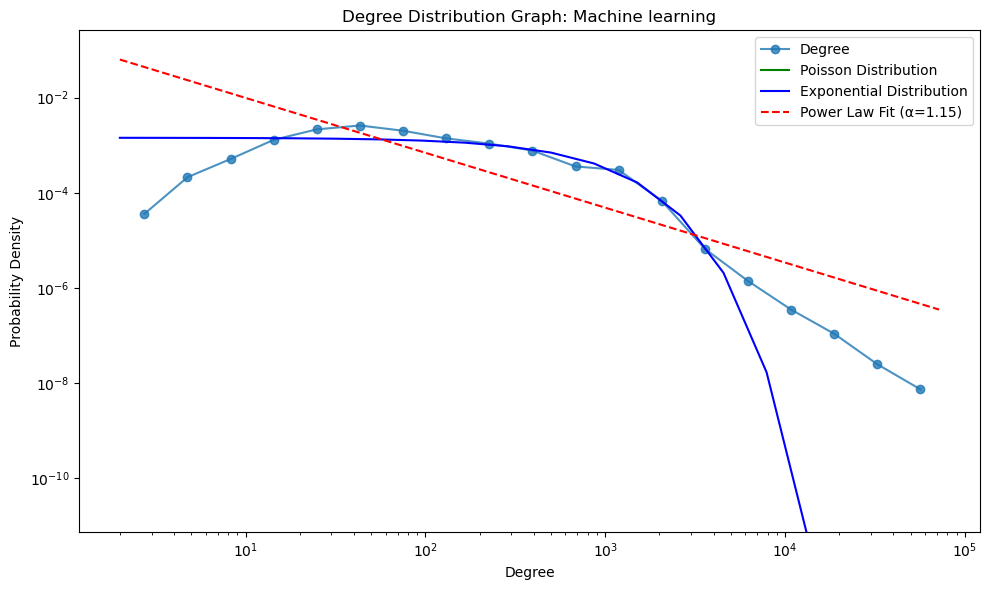


Power Law Analysis:
Minimum degree considered (xmin): 1
Number of nodes in tail: 75217
Power law exponent (α): 1.153 ± 0.001


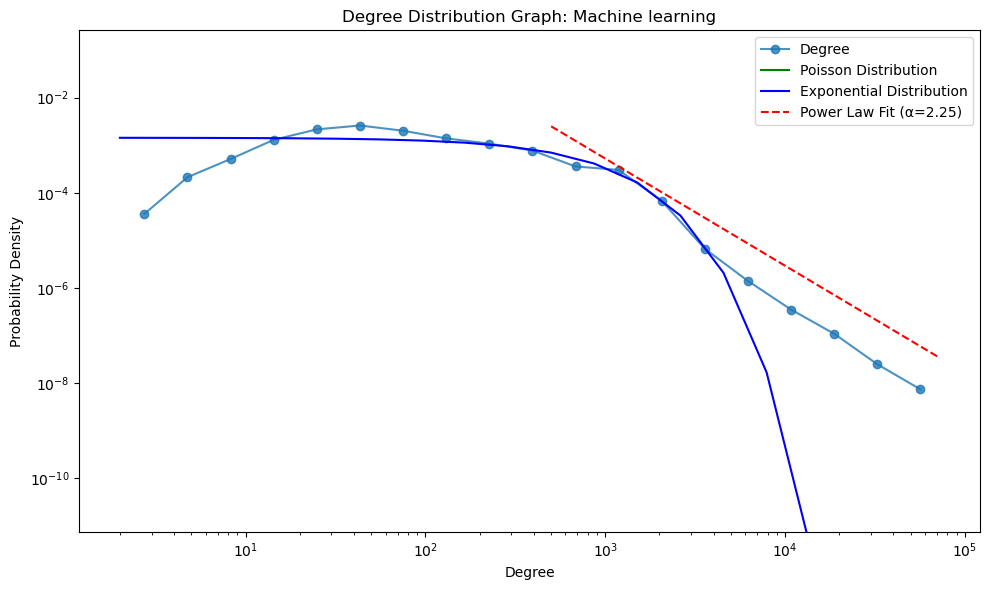


Power Law Analysis:
Minimum degree considered (xmin): 500
Number of nodes in tail: 31752
Power law exponent (α): 2.252 ± 0.007


In [93]:
scale_free_analyzer = ScaleFreeAnalyzer(G)
scale_free_analyzer.calculate_power_law_degree_distribution()
scale_free_analyzer.plot_degree_distribution('Machine learning')
scale_free_analyzer.set_filter(5*10**2)
scale_free_analyzer.plot_degree_distribution('Machine learning')